# Further preprocessed the property data
This notebook is to preprocess the listing property data that were primarily cleaned from the domain_1.ipynb

### import packages

In [71]:
import pandas as pd
import requests
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import geopandas as gpd

In [72]:
listings = pd.read_csv('../data/raw/listings.csv')

In [73]:
listings.head()

,Location,type_property,price,LT_resident_pcg,owner_pcg,family_pcg,state,rooms,bath,parking,...,public_1,public_1_dis,public_2,public_2_dis,private_1,private_1_dis,pulic_1_dis,pulic_2_dis,rent,is_furnished
0,1507/220 Spencer Street Melbourne VIC 3000,Apartment / Unit / Flat,$430pw,12.0,28.0,27.0,VIC,0.0,1.0,NaN,...,Docklands Primary School,1.0,University High School,2.1,Eltham College - King Street Campus,0.3,1.0,2.1,430.0,False
1,4506/33 Rose Lane Melbourne VIC 3000,Apartment / Unit / Flat,$520 per week,12.0,28.0,27.0,VIC,1.0,1.0,NaN,...,Docklands Primary School,1.1,University High School,2.0,Ozford College - Ozford College Campus,0.3,1.1,2.0,520.0,False
2,1715/220 Spencer Street Melbourne VIC 3000,Apartment / Unit / Flat,$750,12.0,28.0,27.0,VIC,2.0,2.0,1.0,...,Docklands Primary School,1.0,University High School,2.1,Eltham College - King Street Campus,0.3,1.0,2.1,750.0,False
3,3504/220 Spencer Street Melbourne VIC 3000,Apartment / Unit / Flat,$400 per week,12.0,28.0,27.0,VIC,0.0,1.0,NaN,...,Docklands Primary School,1.0,University High School,2.1,Eltham College - King Street Campus,0.3,1.0,2.1,400.0,False
4,512/118 Franklin Street Melbourne VIC 3000,Apartment / Unit / Flat,$430,NaN,29.0,16.0,VIC,1.0,1.0,NaN,...,Carlton Gardens Primary School,1.2,University High School,1.3,River Nile School,0.5,1.2,1.3,430.0,False


# Delete Properties that are not for Residential Purposes/that contain too little information

In [74]:
# check the types of property available
listings.groupby('type_property').count()

,Location,price,LT_resident_pcg,owner_pcg,family_pcg,state,rooms,bath,parking,link,public_1,public_1_dis,public_2,public_2_dis,private_1,private_1_dis,pulic_1_dis,pulic_2_dis,rent,is_furnished
type_property,,,,,,,,,,,,,,,,,,,,
Acreage / Semi-Rural,12,12,11,11,11,12,10,10,6,12,12,12,12,12,9,9,12,12,10,12
Apartment / Unit / Flat,4855,4855,4292,4817,4814,4855,4848,4848,3476,4855,4850,4850,4840,4840,4783,4783,4850,4840,4654,4855
Block of Units,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Carspace,15,15,14,15,15,15,11,11,11,15,15,15,15,15,15,15,15,15,13,15
Duplex,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1
Farm,3,3,3,3,3,3,2,2,2,3,3,3,3,3,3,3,3,3,0,3
House,5906,5906,4988,5641,5636,5906,5891,5891,5299,5906,5905,5905,5889,5889,5519,5519,5905,5889,5605,5906
New Apartments / Off the Plan,4,4,4,4,4,4,4,4,3,4,4,4,4,4,4,4,4,4,3,4
New House & Land,4,4,3,3,3,4,4,4,1,4,4,4,4,4,4,4,4,4,3,4


A property that has no room but is not a studio is considered falsely specified or have too much missing information as number of rooms is one crucial information for rental decisions. Since the target of this project is price analyse, a property will also be deleted if there's no price available. If the property has no location available, it will also be deleted since we want to analyse the main suburbs effecting prices.

A property that is a studio is considered to have 1 room regardless of what it is labeled as due to the property structure 

In [75]:
kept_types = ['Apartment / Unit / Flat', 'House','Studio','Townhouse','Villa']
for i in range(listings.shape[0]):
    # Only keep the Apartment/house/studio/townhouse/villa
    if not listings.loc[i,'type_property'] in kept_types:
        # delete the non-relevant property types
        listings.drop(i, inplace=True)

    #not studios but with no room
    elif listings.loc[i, 'type_property'] != 'Studio' and (np.isnan(listings.loc[i, 'rooms']) or listings.loc[i, 'rooms']==0):
        # Delete house/aparment with no room 
        listings.drop(i, inplace=True)
        
    # does not have available price
    elif not listings.loc[i, 'rent'] or listings.loc[i, 'rent'] == 0:
        listings.drop(i, inplace=True)

    # does not have an available location
    elif not listings.loc[i, 'Location']:
        listings.drop(i, inplace=True)   

listings.loc[listings['type_property']=='Studio', 'rooms'] = 1

In [76]:
listings.shape

(12061, 21)

In [77]:
# Fill the nan value for number of parking 
# When number of parking is not indicated on the website, it is naturally assumed that the property has no parking
listings['parking'].fillna(0, inplace=True)

In [78]:
listings.head()

,Location,type_property,price,LT_resident_pcg,owner_pcg,family_pcg,state,rooms,bath,parking,...,public_1,public_1_dis,public_2,public_2_dis,private_1,private_1_dis,pulic_1_dis,pulic_2_dis,rent,is_furnished
1,4506/33 Rose Lane Melbourne VIC 3000,Apartment / Unit / Flat,$520 per week,12.0,28.0,27.0,VIC,1.0,1.0,0.0,...,Docklands Primary School,1.1,University High School,2.0,Ozford College - Ozford College Campus,0.3,1.1,2.0,520.0,False
2,1715/220 Spencer Street Melbourne VIC 3000,Apartment / Unit / Flat,$750,12.0,28.0,27.0,VIC,2.0,2.0,1.0,...,Docklands Primary School,1.0,University High School,2.1,Eltham College - King Street Campus,0.3,1.0,2.1,750.0,False
4,512/118 Franklin Street Melbourne VIC 3000,Apartment / Unit / Flat,$430,NaN,29.0,16.0,VIC,1.0,1.0,0.0,...,Carlton Gardens Primary School,1.2,University High School,1.3,River Nile School,0.5,1.2,1.3,430.0,False
5,5801/648 Lonsdale Street Melbourne VIC 3000,Apartment / Unit / Flat,$800,12.0,20.0,34.0,VIC,2.0,2.0,0.0,...,Docklands Primary School,1.0,University High School,1.9,Ozford College - Ozford College Campus,0.2,1.0,1.9,800.0,False
6,1.2/187 Collins Street Melbourne VIC 3000,Apartment / Unit / Flat,$475 pw,37.0,49.0,51.0,VIC,1.0,1.0,0.0,...,Carlton Gardens Primary School,1.5,University High School,2.3,Stott's Colleges,0.5,1.5,2.3,475.0,False


In [79]:
# reset the index of the dataframe
listings.index = range(listings.shape[0])

In [80]:
listings.columns

Index(['Location', 'type_property', 'price', 'LT_resident_pcg', 'owner_pcg',
       'family_pcg', 'state', 'rooms', 'bath', 'parking', 'link', 'public_1',
       'public_1_dis', 'public_2', 'public_2_dis', 'private_1',
       'private_1_dis', 'pulic_1_dis', 'pulic_2_dis', 'rent', 'is_furnished'],
      dtype='object')

# Check the range for numerical features and Decide Filtering method

In [81]:
# check the range
columns_to_check = ['LT_resident_pcg', 'owner_pcg', 'family_pcg', 'rooms', 'bath', 'parking','public_1_dis','public_2_dis','private_1_dis','rent']
listings[columns_to_check].min(), listings[columns_to_check].max()

(LT_resident_pcg    2.000000
 owner_pcg          0.000000
 family_pcg         2.000000
 rooms              0.000000
 bath               0.000000
 parking            0.000000
 public_1_dis       0.000000
 public_2_dis       0.100000
 private_1_dis      0.000000
 rent               9.195402
 dtype: float64,
 LT_resident_pcg        88.0
 owner_pcg             100.0
 family_pcg            100.0
 rooms                  10.0
 bath                   12.0
 parking                20.0
 public_1_dis           23.4
 public_2_dis           47.7
 private_1_dis          93.1
 rent               565000.0
 dtype: float64)

<AxesSubplot:>

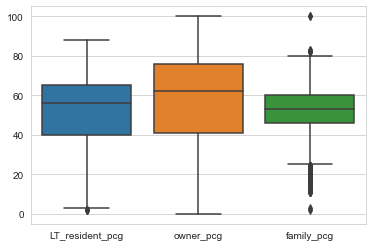

In [82]:
# Plot a boxplot for all the numerical columns to see the distribution
# plot all the numberical values based on percentage as they are of the same scale
pcg_cols = ['LT_resident_pcg', 'owner_pcg', 'family_pcg']
sns.boxplot(listings[pcg_cols])

less than 2 percent and more that 98 percent are considered extreme values and removed. Since there will be external dataset that will be applied to fill the nan values, they are left as nan. The original nan value will also not be removed but left for now

In [83]:
for i in range(0, listings.shape[0]):
    for col in pcg_cols:
        if listings.loc[i, col]<2 or listings.loc[i, col]>98 :
            listings.loc[i, col] = np.nan

In [84]:
listings[['LT_resident_pcg', 'owner_pcg', 'family_pcg']].isna().sum()

LT_resident_pcg    1547
owner_pcg           363
family_pcg          335
dtype: int64

<AxesSubplot:>

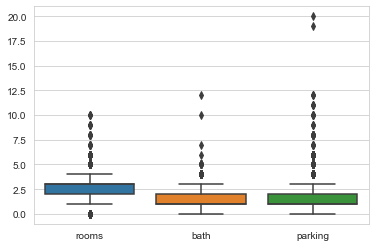

In [85]:
# plot a graph for the number of rooms, bath and parking
sns.boxplot(listings[['rooms','bath','parking']])

no unreasonable outliers are observed, therefore not removing any features

<AxesSubplot:>

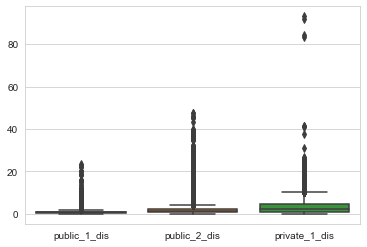

In [86]:
# plot a graph for distance
dis_cols = ['public_1_dis', 'public_2_dis', 'private_1_dis']
schools_cols = ['public_1', 'public_2', 'private_1']
sns.boxplot(listings[dis_cols])

It can be observed that there are some very high distance presented. As to general knowledge, if the closest school to a property is more than 10 km away, it can be considered as there are no school in the neighbourhood as the transition cost would be extremely high. Therefore, we remove schools that are more than 10 km away from the property

For school related columns, an nan value indicate that there's no school in the 10km radius satisfy the specific criteria

In [87]:
for i in range(listings.shape[0]):
    for col in schools_cols:
        if listings.loc[i, f'{col}_dis']>10:
            listings.loc[i, col] = np.nan
            listings.loc[i, f'{col}_dis'] = np.nan

<AxesSubplot:>

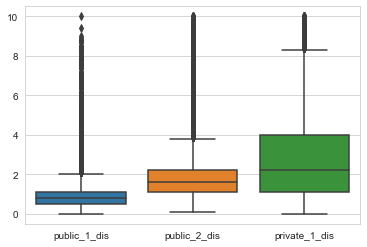

In [88]:
# plot another graph now the outliers are dropped 
sns.boxplot(listings[dis_cols])

<AxesSubplot:>

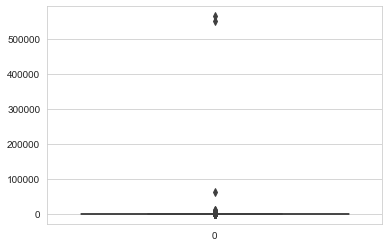

In [89]:
# plot a boxplot for the rent column
sns.boxplot(listings['rent'])

It can be observed that there are two extreme outlier, Let's see some detail about that outlier

In [90]:
listings.loc[listings['rent'] == listings['rent'].max()]

,Location,type_property,price,LT_resident_pcg,owner_pcg,family_pcg,state,rooms,bath,parking,...,public_1,public_1_dis,public_2,public_2_dis,private_1,private_1_dis,pulic_1_dis,pulic_2_dis,rent,is_furnished
8965,52 Lava Street Warrnambool VIC 3280,House,"$565,000",56.0,54.0,47.0,VIC,2.0,1.0,1.0,...,Warrnambool Primary School,0.9,Warrnambool College,1.2,Merri River School,3.3,0.9,1.2,565000.0,False


It can be inferred that the property is misclassified as for rent but is actually for sale which explain the extreme high price

In [91]:
# drop the outlier
listings.drop(listings.loc[listings['rent'] == listings['rent'].max()].index[0], inplace=True)

In [92]:
# see some detail about the second extreme outlier
listings.loc[listings['rent'] == listings['rent'].max()]

,Location,type_property,price,LT_resident_pcg,owner_pcg,family_pcg,state,rooms,bath,parking,...,public_1,public_1_dis,public_2,public_2_dis,private_1,private_1_dis,pulic_1_dis,pulic_2_dis,rent,is_furnished
7887,11 Addicott Street Frankston VIC 3199,House,"$550,000 - $599,000",49.0,50.0,41.0,VIC,3.0,1.0,2.0,...,Frankston East Primary School,0.8,McClelland Secondary College,1.8,Naranga Special School,2.3,0.8,1.8,550000.0,False


again a property is misclassified as for rent but is actually for sale, we drop the row

In [93]:
listings.drop(listings.loc[listings['rent'] == listings['rent'].max()].index[0], inplace=True)

<AxesSubplot:>

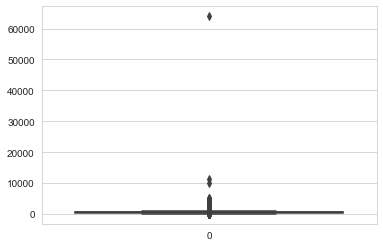

In [94]:
# plot another graph 
sns.boxplot(listings['rent'])

Still an extreme outliers, let's see what is entails

In [95]:
listings.loc[listings['rent'] == listings['rent'].max()]

,Location,type_property,price,LT_resident_pcg,owner_pcg,family_pcg,state,rooms,bath,parking,...,public_1,public_1_dis,public_2,public_2_dis,private_1,private_1_dis,pulic_1_dis,pulic_2_dis,rent,is_furnished
8153,37/8 Graham Street Port Melbourne VIC 3207,Apartment / Unit / Flat,"$640,00 per week",32.0,46.0,58.0,VIC,2.0,1.0,2.0,...,Albert Park College,0.4,Port Phillip Specialist School,0.6,Port Melbourne Primary School,1.2,0.4,0.6,64000.0,False


It seems that it uses a ',' for '.' which lead to the misclassification when doing value extraction, check if this is a common issue 

In [96]:
listings.loc[listings['rent']>listings['rent'].quantile( q=0.99)].sort_values('rent', ascending=False).head(10)

,Location,type_property,price,LT_resident_pcg,owner_pcg,family_pcg,state,rooms,bath,parking,...,public_1,public_1_dis,public_2,public_2_dis,private_1,private_1_dis,pulic_1_dis,pulic_2_dis,rent,is_furnished
8153,37/8 Graham Street Port Melbourne VIC 3207,Apartment / Unit / Flat,"$640,00 per week",32.0,46.0,58.0,VIC,2.0,1.0,2.0,...,Albert Park College,0.4,Port Phillip Specialist School,0.6,Port Melbourne Primary School,1.2,0.4,0.6,64000.0,False
11714,28A McCartin Street Leongatha VIC 3953,Studio,"$11,471.00 exc gst",52.0,64.0,54.0,VIC,1.0,1.0,0.0,...,Leongatha Primary School,1.3,Leongatha Secondary College,1.4,St Laurence O'Toole School,0.9,1.3,1.4,11471.0,False
4732,1 Weston Street Balwyn VIC 3103,House,"$9,950 weekly",69.0,75.0,53.0,VIC,6.0,7.0,8.0,...,Balwyn Primary School,0.4,Balwyn High School,1.5,Bulleen Heights School-Manningham Road Campus,5.0,0.4,1.5,9950.0,False
461,4807/27 Therry Street Melbourne VIC 3000,Apartment / Unit / Flat,$5000 per week,NaN,29.0,16.0,VIC,3.0,3.0,1.0,...,Carlton Gardens Primary School,0.9,University High School,1.2,River Nile School,0.6,0.9,1.2,5000.0,False
1108,8701/7 Riverside Quay Southbank VIC 3006,Apartment / Unit / Flat,"$5,000.00",23.0,48.0,56.0,VIC,3.0,3.0,4.0,...,South Melbourne Primary School,1.3,Port Phillip Specialist School,2.6,Collingwood College,3.1,1.3,2.6,5000.0,False
8738,335 The Esplanade Indented Head VIC 3223,House,"$4,700 pw /$700 pn high, $3,775 pw/$545 pn low",47.0,84.0,68.0,VIC,4.0,3.0,0.0,...,St Leonards Primary School,3.1,NaN,NaN,NaN,NaN,3.1,14.8,4700.0,False
118,3605/439 Collins Street Melbourne VIC 3000,Apartment / Unit / Flat,"$4,500 per week",18.0,28.0,39.0,VIC,4.0,3.0,2.0,...,Docklands Primary School,1.7,University High School,2.3,Hester Hornbrook Academy - City Campus,0.3,1.7,2.3,4500.0,False
11677,9 Lansdowne Street Blairgowrie VIC 3942,House,"$4,500 per week",58.0,76.0,63.0,VIC,3.0,2.0,3.0,...,Rye Primary School,3.3,Rosebud Secondary College,8.9,NaN,NaN,3.3,8.9,4500.0,False
972,1706/499 St Kilda Road Melbourne VIC 3004,Apartment / Unit / Flat,$3950 per week,36.0,61.0,55.0,VIC,5.0,5.0,4.0,...,South Yarra Primary School,0.6,Prahran High School,1.4,Port Phillip Specialist School,3.4,0.6,1.4,3950.0,False
8911,7 Karlson Street Skenes Creek VIC 3233,House,"$3,850",73.0,89.0,70.0,VIC,3.0,2.0,4.0,...,Apollo Bay P-12 College,5.2,NaN,NaN,NaN,NaN,5.2,43.4,3850.0,False


It seems that the column with the highest value was the only column with that problem, we fix it and plot another graph


In [97]:
listings.loc[listings['rent']==listings['rent'].max(), 'rent'] = listings.loc[listings['rent']==listings['rent'].max(), 'rent']/100

The second highest studio seem to have a misclassified price, as a 1 room studio cannot cost over 10000 a week and there's no indication whether the labelled price is month or season or year, so we choose to drop it. The other properties do have a high price, but are still reasonable

In [98]:
listings.drop(listings.loc[listings['rent'] == listings['rent'].max()].index[0], inplace=True)

<AxesSubplot:>

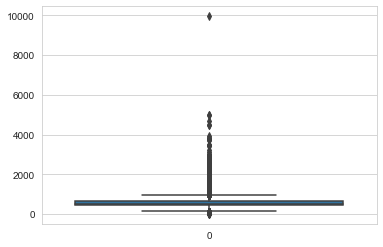

In [99]:
# now plot the final boxplot
sns.boxplot(listings['rent'])

now lets look at the outliers with too low a rent

In [100]:
listings.loc[listings['rent']<listings['rent'].quantile(q=0.001)].sort_values('rent')

,Location,type_property,price,LT_resident_pcg,owner_pcg,family_pcg,state,rooms,bath,parking,...,public_1,public_1_dis,public_2,public_2_dis,private_1,private_1_dis,pulic_1_dis,pulic_2_dis,rent,is_furnished
528,Storage Cage/228 La Trobe Street Melbourne VIC...,House,$40 per month,13.0,15.0,17.0,VIC,1.0,1.0,0.0,...,Carlton Gardens Primary School,1.1,University High School,1.5,Eltham College - Lonsdale Street Campus,0.4,1.1,1.5,9.195402,False
12051,120-127 Mc Kenzie Street Wonthaggi VIC 3995,Apartment / Unit / Flat,$77 per calendar month,57.0,62.0,51.0,VIC,1.0,1.0,0.0,...,Wonthaggi North Primary School,0.6,Bass Coast College,1.4,St Joseph's School,1.0,0.6,1.4,17.701149,False
10508,367 Merriang South Road Myrtleford VIC 3737,House,from $25 per week,72.0,86.0,66.0,VIC,1.0,1.0,0.0,...,Myrtleford P-12 College,7.2,NaN,NaN,NaN,NaN,7.2,NaN,25.000000,False
10505,8 Mcgeehan Cres Myrtleford VIC 3737,Apartment / Unit / Flat,$32.50 - $44.00 per week,70.0,77.0,53.0,VIC,1.0,1.0,9.0,...,Myrtleford P-12 College,0.9,Marian College,0.5,St Mary's School,0.7,0.9,0.5,32.000000,False
11047,14-16 Bubb Street Moe VIC 3825,House,from $33pw,61.0,42.0,37.0,VIC,1.0,1.0,0.0,...,Moe (Albert Street) Primary School,0.8,Lowanna College,2.6,St Kieran's School,1.1,0.8,2.6,33.000000,False
12024,40-42 Watts Road Nyora VIC 3987,House,$34.52 per week,58.0,92.0,68.0,VIC,1.0,1.0,0.0,...,Nyora Primary School,0.8,NaN,NaN,NaN,NaN,0.8,17.2,34.000000,False
527,68 Hayward Lane Melbourne VIC 3000,House,$150 per month,15.0,29.0,25.0,VIC,1.0,1.0,1.0,...,Carlton Gardens Primary School,0.8,University High School,1.7,Ozford College,0.2,0.8,1.7,34.482759,False
11716,0 Cnr Watson Rd & McPherson Rd Leongatha VIC 3953,House,from $160 - $170 per month,62.0,79.0,53.0,VIC,1.0,1.0,0.0,...,Leongatha Primary School,1.1,Leongatha Secondary College,1.2,Chairo Christian School - Leongatha Campus,0.4,1.1,1.2,36.781609,False
7009,2 Jarvis Crescent Dandenong North VIC 3175,House,$40 per week leased,55.0,73.0,52.0,VIC,3.0,1.0,2.0,...,Dandenong North Primary School,0.8,Dandenong High School,1.4,NaN,NaN,0.8,1.4,40.000000,False
711,CP2709/31 ABeckett Street Melbourne VIC 3000,Apartment / Unit / Flat,$50 per week,NaN,14.0,19.0,VIC,1.0,1.0,1.0,...,Carlton Gardens Primary School,1.0,University High School,1.5,Eltham College - Lonsdale Street Campus,0.4,1.0,1.5,50.000000,False


all of them seem genuie so left as they are

# Get Lantitude and Longtitude of the Property

please note that the api free limit has been reached. Since I don't want to be charged, please don't run the following code again

In [101]:
# get a reordered index since some are rows are dropped
listings.index = range(listings.shape[0])

In [102]:
def get_lat_lng(apiKey, address):
    '''Using google map api, get the longitude and latitude of the address'''
    url = f"https://maps.googleapis.com/maps/api/geocode/json?key={apiKey}&address={address}"
    response = requests.get(url)
    data = response.json()
    if data['status'] == 'OK':
        latitude = data['results'][0]['geometry']['location']['lat']
        longitude = data['results'][0]['geometry']['location']['lng']
        return latitude, longitude
    else:
        return None

In [104]:
apiKey = "http://localhost:5050/ors"
i = 0

while i < listings.shape[0]:

    address = listings.loc[i, 'Location']
    coordinates = get_lat_lng(apiKey, address)
    
    # some unstable internet at my place 
    # if connection error, run the
    # current row again

        
    if coordinates:
        listings.loc[i, "latitude"] = coordinates[0]
        listings.loc[i, 'longitude'] = coordinates[1]

    else:
        print(f'unable to get coordinate {address}')
    if i%100 ==0:
        print(f'processed up to {i}th row')
        print(coordinates)
    
    i = i + 1

processed up to 0th row
(-37.8150001, 144.9538708)
processed up to 100th row
(-37.8095116, 144.9691204)
processed up to 200th row
(-37.8115161, 144.9606515)
processed up to 300th row
(-37.8173563, 144.9558241)
processed up to 400th row
(-37.8072179, 144.9623358)
processed up to 500th row
(-37.8075296, 144.9590537)
processed up to 600th row
(-37.8144958, 144.9522648)
processed up to 700th row
(-37.8076799, 144.9669603)
processed up to 800th row
(-37.8080736, 144.9695946)
processed up to 900th row
(-37.8083807, 144.9495901)
processed up to 1000th row
(-37.8470519, 144.9806754)
processed up to 1100th row
(-37.829259, 144.9585792)
processed up to 1200th row
(-37.8253713, 144.9665034)
processed up to 1300th row
(-37.8298844, 144.9679382)
processed up to 1400th row
(-37.8216688, 144.9509893)
processed up to 1500th row
(-37.8132118, 144.9431755)
processed up to 1600th row
(-37.7882986, 144.8840389)
processed up to 1700th row
(-37.7837522, 144.8706501)
processed up to 1800th row
(-37.8652609, 

In [108]:
# Drop properties with unaccessible location information
listings.dropna(subset=['longitude', 'latitude'], inplace=True)

In [109]:
listings.head()

,Location,type_property,price,LT_resident_pcg,owner_pcg,family_pcg,state,rooms,bath,parking,...,public_2,public_2_dis,private_1,private_1_dis,pulic_1_dis,pulic_2_dis,rent,is_furnished,latitude,longitude
0,4506/33 Rose Lane Melbourne VIC 3000,Apartment / Unit / Flat,$520 per week,12.0,28.0,27.0,VIC,1.0,1.0,0.0,...,University High School,2.0,Ozford College - Ozford College Campus,0.3,1.1,2.0,520.0,False,-37.815000,144.953871
1,1715/220 Spencer Street Melbourne VIC 3000,Apartment / Unit / Flat,$750,12.0,28.0,27.0,VIC,2.0,2.0,1.0,...,University High School,2.1,Eltham College - King Street Campus,0.3,1.0,2.1,750.0,False,-37.815781,144.952916
2,512/118 Franklin Street Melbourne VIC 3000,Apartment / Unit / Flat,$430,NaN,29.0,16.0,VIC,1.0,1.0,0.0,...,University High School,1.3,River Nile School,0.5,1.2,1.3,430.0,False,-37.808205,144.958903
3,5801/648 Lonsdale Street Melbourne VIC 3000,Apartment / Unit / Flat,$800,12.0,20.0,34.0,VIC,2.0,2.0,0.0,...,University High School,1.9,Ozford College - Ozford College Campus,0.2,1.0,1.9,800.0,False,-37.814454,144.953443
4,1.2/187 Collins Street Melbourne VIC 3000,Apartment / Unit / Flat,$475 pw,37.0,49.0,51.0,VIC,1.0,1.0,0.0,...,University High School,2.3,Stott's Colleges,0.5,1.5,2.3,475.0,False,-37.815405,144.967852


In [134]:
listings.to_csv("../data/curated/listings.csv", index=False)


# Get the SA2 region that each property belongs to 

In [110]:
import geopandas as gpd
from shapely.geometry import Point
import folium

In [113]:
# Get the shpaefile for SA2 region
suburbs = gpd.read_file("../data/landing/SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp")

# select the subset that we care about
suburbs = suburbs.loc[suburbs['STE_NAME21']=='Victoria']
suburbs = suburbs[['SA2_CODE21','SA2_NAME21','geometry']]

In [114]:
# Convert the dataframe to a geodataframe
geometry = [Point(xy) for xy in zip(listings['longitude'], listings['latitude'])]
listings_gdf = gpd.GeoDataFrame(listings, geometry=geometry)

In [115]:
# Use sjoin to find out which suburb each point belongs to
joined = gpd.sjoin(listings_gdf, suburbs, how="left", op="within")

# If your suburbs shapefile has a column named 'suburb_name' that specifies the name of the suburb
listings_gdf['SA2_NAME'] = joined['SA2_NAME21']
listings_gdf['SA2_CODE'] = joined['SA2_CODE21']

/opt/homebrew/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3361: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-115-2c2111036663>:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: GEOGCS["GDA2020",DATUM["GDA2020",SPHEROID["GRS_198 ...

  joined = gpd.sjoin(listings_gdf, suburbs, how="left", op="within")


In [121]:
listings_gdf.head()

,Location,type_property,price,LT_resident_pcg,owner_pcg,family_pcg,state,rooms,bath,parking,...,private_1_dis,pulic_1_dis,pulic_2_dis,rent,is_furnished,latitude,longitude,geometry,SA2_NAME,SA2_CODE
0,4506/33 Rose Lane Melbourne VIC 3000,Apartment / Unit / Flat,$520 per week,12.0,28.0,27.0,VIC,1.0,1.0,0.0,...,0.3,1.1,2.0,520.0,False,-37.815000,144.953871,POINT (144.95387 -37.81500),Melbourne CBD - West,206041505
1,1715/220 Spencer Street Melbourne VIC 3000,Apartment / Unit / Flat,$750,12.0,28.0,27.0,VIC,2.0,2.0,1.0,...,0.3,1.0,2.1,750.0,False,-37.815781,144.952916,POINT (144.95292 -37.81578),Melbourne CBD - West,206041505
2,512/118 Franklin Street Melbourne VIC 3000,Apartment / Unit / Flat,$430,NaN,29.0,16.0,VIC,1.0,1.0,0.0,...,0.5,1.2,1.3,430.0,False,-37.808205,144.958903,POINT (144.95890 -37.80821),Melbourne CBD - North,206041504
3,5801/648 Lonsdale Street Melbourne VIC 3000,Apartment / Unit / Flat,$800,12.0,20.0,34.0,VIC,2.0,2.0,0.0,...,0.2,1.0,1.9,800.0,False,-37.814454,144.953443,POINT (144.95344 -37.81445),Melbourne CBD - West,206041505
4,1.2/187 Collins Street Melbourne VIC 3000,Apartment / Unit / Flat,$475 pw,37.0,49.0,51.0,VIC,1.0,1.0,0.0,...,0.5,1.5,2.3,475.0,False,-37.815405,144.967852,POINT (144.96785 -37.81540),Melbourne CBD - East,206041503


In [133]:
# save the processed data to curated data file
listings_gdf.to_csv("../data/curated/listings_SA2.csv", index=False)

# Get the suburbs


In [137]:
suburbs = gpd.read_file("../data/landing/SAL_2021_AUST_GDA2020_SHP/SAL_2021_AUST_GDA2020.shp")

In [138]:
# select the subset that we care about
suburbs = suburbs.loc[suburbs['STE_NAME21']=='Victoria']
suburbs = suburbs[['SAL_CODE21', 'SAL_NAME21', 'geometry']]
suburbs.head()

,SAL_CODE21,SAL_NAME21,geometry
4544,20001,Abbeyard,"POLYGON ((146.89824 -37.04602, 146.89947 -37.0..."
4545,20002,Abbotsford (Vic.),"POLYGON ((145.00195 -37.79665, 145.00190 -37.7..."
4546,20003,Aberfeldie,"POLYGON ((144.89576 -37.76514, 144.89547 -37.7..."
4547,20004,Aberfeldy,"POLYGON ((146.38814 -37.72232, 146.38808 -37.7..."
4548,20005,Acheron,"POLYGON ((145.76731 -37.25433, 145.76757 -37.2..."


In [128]:
# Use sjoin to find out which suburb each point belongs to
joined = gpd.sjoin(listings_gdf, suburbs, how="left", op="within")

# If your suburbs shapefile has a column named 'suburb_name' that specifies the name of the suburb
listings_gdf['SAL_NAME21'] = joined['SAL_NAME21']
listings_gdf['SAL_CODE'] = joined['SAL_CODE21']

/opt/homebrew/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3361: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-128-7b47517f056e>:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: GEOGCS["GDA2020",DATUM["GDA2020",SPHEROID["GRS_198 ...

  joined = gpd.sjoin(listings_gdf, suburbs, how="left", op="within")


In [129]:
listings_gdf.head()

,Location,type_property,price,LT_resident_pcg,owner_pcg,family_pcg,state,rooms,bath,parking,...,pulic_2_dis,rent,is_furnished,latitude,longitude,geometry,SA2_NAME,SA2_CODE,SAL_NAME21,SAL_CODE
0,4506/33 Rose Lane Melbourne VIC 3000,Apartment / Unit / Flat,$520 per week,12.0,28.0,27.0,VIC,1.0,1.0,0.0,...,2.0,520.0,False,-37.815000,144.953871,POINT (144.95387 -37.81500),Melbourne CBD - West,206041505,Melbourne,21640
1,1715/220 Spencer Street Melbourne VIC 3000,Apartment / Unit / Flat,$750,12.0,28.0,27.0,VIC,2.0,2.0,1.0,...,2.1,750.0,False,-37.815781,144.952916,POINT (144.95292 -37.81578),Melbourne CBD - West,206041505,Melbourne,21640
2,512/118 Franklin Street Melbourne VIC 3000,Apartment / Unit / Flat,$430,NaN,29.0,16.0,VIC,1.0,1.0,0.0,...,1.3,430.0,False,-37.808205,144.958903,POINT (144.95890 -37.80821),Melbourne CBD - North,206041504,Melbourne,21640
3,5801/648 Lonsdale Street Melbourne VIC 3000,Apartment / Unit / Flat,$800,12.0,20.0,34.0,VIC,2.0,2.0,0.0,...,1.9,800.0,False,-37.814454,144.953443,POINT (144.95344 -37.81445),Melbourne CBD - West,206041505,Melbourne,21640
4,1.2/187 Collins Street Melbourne VIC 3000,Apartment / Unit / Flat,$475 pw,37.0,49.0,51.0,VIC,1.0,1.0,0.0,...,2.3,475.0,False,-37.815405,144.967852,POINT (144.96785 -37.81540),Melbourne CBD - East,206041503,Melbourne,21640


In [131]:
listings_gdf.to_csv("../data/curated/listings_suburbs_SA2.csv", index=False)

In [135]:
listings_gdf.to_file("../data/curated/listings_suburbs_SA2.shp")

<ipython-input-135-5b8921937187>:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  listings_gdf.to_file("../data/curated/listings_suburbs_SA2.shp")
